### Code for Feedforward Neural Network and Convolutional Neural Network for Kaggle and Liar Dataset

In [78]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Input, Dropout, LSTM, Activation, GlobalMaxPool1D, Flatten, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
np.random.seed(125)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [79]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

* Fetch Data

In [ ]:
def kaggle_text_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1BwYx3Mp60_hMSHlsNuNW9fVI2-XHlFrK'})
  fileDownloaded.GetContentFile('data1.csv')
  x_test = pd.read_csv('data1.csv')
  fileDownloaded = drive.CreateFile({'id':'19ddTDm2OvZA-Cdo1Mbji_SrZfOmVi-S1'})
  fileDownloaded.GetContentFile('data2.csv')
  x_train = pd.read_csv('data2.csv')
  fileDownloaded = drive.CreateFile({'id':'1iiE0whOEHDAUGo3-Sc2phR_vEj3_i8DG'})
  fileDownloaded.GetContentFile('data3.csv')
  x_valid = pd.read_csv('data3.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
def kaggle_label_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1fZMyxj--k93sRjn76AwzXvKrzT_l7yve'})
  fileDownloaded.GetContentFile('data4.csv')
  y_test = pd.read_csv('data4.csv')
  fileDownloaded = drive.CreateFile({'id':'1MFPvAsBxbrfnZKA9_mhuqy6Vy5Wj4jZb'})
  fileDownloaded.GetContentFile('data5.csv')
  y_train = pd.read_csv('data5.csv')
  fileDownloaded = drive.CreateFile({'id':'1py-_sIVo13sN2VfosZczZ_vBO5ZmbIJg'})
  fileDownloaded.GetContentFile('data6.csv')
  y_valid = pd.read_csv('data6.csv')

  print(y_test.shape)
  print(y_train.shape)
  print(y_valid.shape)

  return y_test, y_train, y_valid

In [ ]:
def get_vocab():
  fileDownloaded = drive.CreateFile({'id':'1FmCAmUgGYlGuJ3qgnuO5kS6EvMsbkzsb'})
  fileDownloaded.GetContentFile('vocab_text.txt')
  kaggle_vocab_text_size = int(np.loadtxt('vocab_text.txt'))

  fileDownloaded = drive.CreateFile({'id':'1e1D1m08LNKwqBDwIEv7jkvmp49QLKxCG'})
  fileDownloaded.GetContentFile('vocab_title.txt')
  kaggle_vocab_title_size = int(np.loadtxt('vocab_title.txt'))

  fileDownloaded = drive.CreateFile({'id':'1pvzUv4z8qbfic5uVnLSR8zjo77H8v-h8'})
  fileDownloaded.GetContentFile('liar_vocab_text.txt')
  liar_vocab_text_size = int(np.loadtxt('liar_vocab_text.txt'))

  return kaggle_vocab_text_size, kaggle_vocab_title_size, liar_vocab_text_size

In [ ]:
# Model for CNN with Text or Title as feature for Kaggle
def model1(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Conv1D(input_shape=(x_train.shape[1],1),filters=64 ,kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPool1D())
  #model.add(Conv1D(input_shape=(1200,1),filters=128 ,kernel_size=5, padding='same', activation='relu'))
  #model.add(MaxPooling1D(5))
  #model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'],)
  print(model.summary())
  return model

In [ ]:
def fit_model(model, x_train, y_train, x_valid,y_valid, epo):
  history = model.fit(x_train, y_train.to_numpy(), epochs=epo, batch_size = 256, validation_data=(x_valid,y_valid.to_numpy()), verbose=1)
  return history

In [ ]:
def evaluate(model, x_test, y_test):
  loss, acc = model.evaluate(x_test.to_numpy().reshape(x_test.shape[0], x_test.shape[1]), y_test)
  print('Test Accuracy : {}\nLoss : {}'.format(acc,loss))

In [ ]:
def pred_confusion(model, x_test, y_test, classes):
  
  pred = model.predict(x_test.to_numpy().reshape(x_test.shape[0], x_test.shape[1]))
  if classes > 1:
    pred = np.argmax(pred, axis = 1)
    confusion = tf.math.confusion_matrix(y_test.to_numpy(), predictions=pred, num_classes=classes)
  else:
    pred = np.around(pred)
    confusion = confusion_matrix(y_test.to_numpy(), pred)
  print(pred)
  sns.heatmap(confusion, annot = True)
  plt.show()

  print(classification_report(y_test.to_numpy(), pred))

In [ ]:
def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
x_test, x_train, x_valid = kaggle_text_seq_data()

(3652, 1200)
(10942, 1200)
(3617, 1200)


In [ ]:
y_test, y_train, y_valid = kaggle_label_seq_data()

(3652, 1)
(10942, 1)
(3617, 1)


In [ ]:
vocab1, vocab2, vocab3 = get_vocab()

In [ ]:
# Kaggle text CNN model
modelv1 = model1(x_train.shape[1], 0.001, vocab1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 100)         19387400  
                                                                 
 conv1d (Conv1D)             (None, 1200, 64)          19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 19,413,265
Trainable params: 19,413,265
Non-trainable params: 0
____________________________________________

In [ ]:
history = fit_model(modelv1, x_train, y_train, x_valid,y_valid, 5)

Epoch 1/5
43/43 [==============================] - 60s 1s/step - loss: 0.6151 - accuracy: 0.6365 - val_loss: 0.4252 - val_accuracy: 0.9146
Epoch 2/5
43/43 [==============================] - 59s 1s/step - loss: 0.1890 - accuracy: 0.9528 - val_loss: 0.0830 - val_accuracy: 0.9704
Epoch 3/5
43/43 [==============================] - 59s 1s/step - loss: 0.0359 - accuracy: 0.9907 - val_loss: 0.0547 - val_accuracy: 0.9820
Epoch 4/5
43/43 [==============================] - 60s 1s/step - loss: 0.0092 - accuracy: 0.9991 - val_loss: 0.0505 - val_accuracy: 0.9809
Epoch 5/5
43/43 [==============================] - 59s 1s/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.0473 - val_accuracy: 0.9820


In [ ]:
evaluate(modelv1, x_test, y_test)

115/115 [==============================] - 5s 40ms/step - loss: 0.0508 - accuracy: 0.9827
Test Accuracy : 0.9827491641044617
Loss : 0.050775982439517975


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


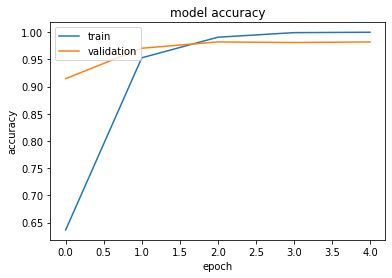

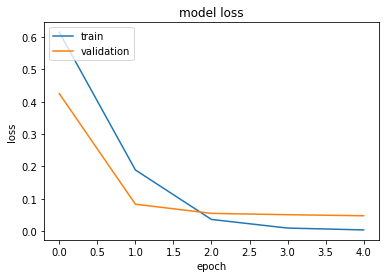

In [ ]:
# Kaggle Text CNN 
print(history.history.keys())
plot_history(history)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


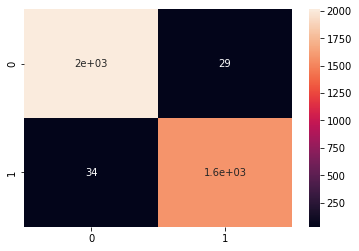

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2042
           1       0.98      0.98      0.98      1610

    accuracy                           0.98      3652
   macro avg       0.98      0.98      0.98      3652
weighted avg       0.98      0.98      0.98      3652



In [ ]:
pred_confusion(modelv1, x_test, y_test, 1)

In [ ]:
modelv1.save('v1.model')

INFO:tensorflow:Assets written to: v1.model/assets


In [ ]:
# Model for FNN with Text or Title as feature for Kaggle

def model2(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(GlobalMaxPool1D())
  model.add(Dense(units = 100 , activation = 'relu' ,input_shape=(shape,1)))
  model.add(Dense(units = 50 , activation = 'relu'))
  model.add(Dense(units = 25 , activation = 'relu'))
  model.add(Dense(units = 10 , activation = 'relu'))
  model.add(Dense(units = 1 , activation = 'sigmoid'))
  model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
  print(model.summary())
  return model

In [ ]:
# Kaggle text FNN
modelv2 = model2(x_train.shape[1], 0.001, vocab1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1200, 100)         19387400  
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                      

In [ ]:
history = fit_model(modelv2, x_train, y_train, x_valid,y_valid, 5)

Epoch 1/5
43/43 [==============================] - 19s 424ms/step - loss: 0.6734 - accuracy: 0.5650 - val_loss: 0.6321 - val_accuracy: 0.5803
Epoch 2/5
43/43 [==============================] - 18s 416ms/step - loss: 0.4415 - accuracy: 0.7979 - val_loss: 0.2173 - val_accuracy: 0.9563
Epoch 3/5
43/43 [==============================] - 18s 416ms/step - loss: 0.0856 - accuracy: 0.9782 - val_loss: 0.0941 - val_accuracy: 0.9635
Epoch 4/5
43/43 [==============================] - 18s 418ms/step - loss: 0.0196 - accuracy: 0.9952 - val_loss: 0.0695 - val_accuracy: 0.9740
Epoch 5/5
43/43 [==============================] - 18s 413ms/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 0.0741 - val_accuracy: 0.9732


In [ ]:
evaluate(modelv2, x_test, y_test)

115/115 [==============================] - 1s 10ms/step - loss: 0.0816 - accuracy: 0.9688
Test Accuracy : 0.9687842130661011
Loss : 0.08161941170692444


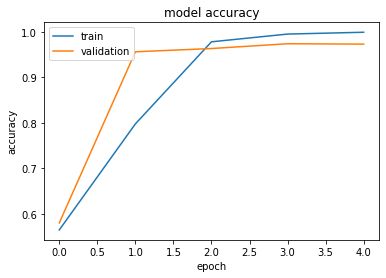

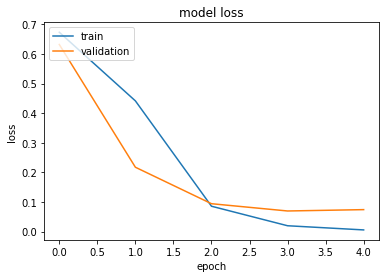

In [ ]:
plot_history(history)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


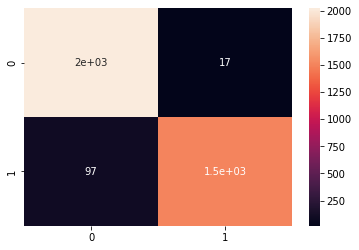

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2042
           1       0.99      0.94      0.96      1610

    accuracy                           0.97      3652
   macro avg       0.97      0.97      0.97      3652
weighted avg       0.97      0.97      0.97      3652



In [ ]:
pred_confusion(modelv2, x_test, y_test, 1)

In [ ]:
modelv2.save('v2.model')

INFO:tensorflow:Assets written to: v2.model/assets


In [ ]:
def kaggle_title_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1Ws0wRmdWzyrflqaMzktGMMQE6mx5aeEO'})
  fileDownloaded.GetContentFile('data7.csv')
  x_test = pd.read_csv('data7.csv')
  fileDownloaded = drive.CreateFile({'id':'1t1pArqIsRlNcOhcZaFWugTFfvl_-RBDP'})
  fileDownloaded.GetContentFile('data8.csv')
  x_train = pd.read_csv('data8.csv')
  fileDownloaded = drive.CreateFile({'id':'1H7x7-6IYPbSmMV7elq7U2qVwVHh0fwwO'})
  fileDownloaded.GetContentFile('data9.csv')
  x_valid = pd.read_csv('data9.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
x_test, x_train, x_valid = kaggle_title_seq_data()

(3652, 30)
(10942, 30)
(3617, 30)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           2262500   
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            19264     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 100)               6500      
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,288,365
Trainable params: 2,288,365
Non-trainable params: 0
____________________________________________

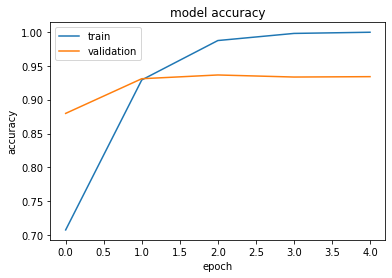

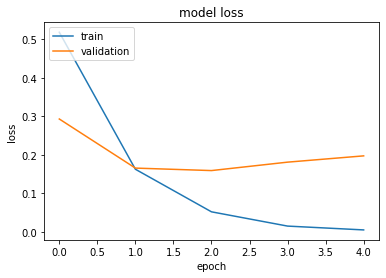

115/115 [==============================] - 1s 4ms/step - loss: 0.1888 - accuracy: 0.9367
Test Accuracy : 0.9367470145225525
Loss : 0.18876521289348602
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


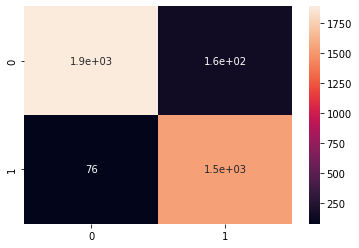

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2042
           1       0.91      0.95      0.93      1610

    accuracy                           0.94      3652
   macro avg       0.93      0.94      0.94      3652
weighted avg       0.94      0.94      0.94      3652



In [ ]:
# Kaggle Title CNN
modelv1 = model1(x_train.shape[1], 0.001, vocab2)
history = fit_model(modelv1, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv1, x_test, y_test)
pred_confusion(modelv1, x_test, y_test, 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 100)           2262500   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 25)                1275      
                                                                 
 dense_12 (Dense)            (None, 10)                260       
                                                      

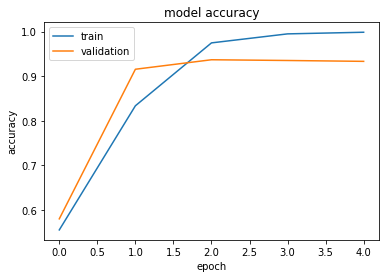

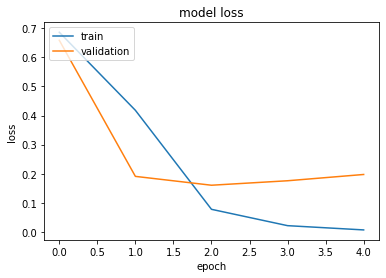

115/115 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9354
Test Accuracy : 0.9353778958320618
Loss : 0.19278378784656525
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


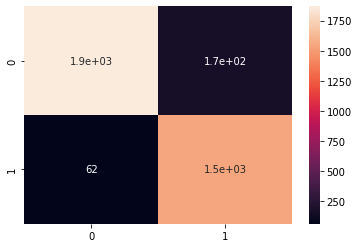

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2042
           1       0.90      0.96      0.93      1610

    accuracy                           0.94      3652
   macro avg       0.93      0.94      0.93      3652
weighted avg       0.94      0.94      0.94      3652



In [ ]:
# Kaggle Title FNN
modelv2 = model2(x_train.shape[1], 0.001, vocab2)
history = fit_model(modelv2, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv2, x_test, y_test)
pred_confusion(modelv2, x_test, y_test, 1)

In [ ]:
def liar_word_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1hgBqRUoxN5zZm7ULQS70MUr8CWWvy6ka'})
  fileDownloaded.GetContentFile('data10.csv')
  x_test = pd.read_csv('data10.csv')
  fileDownloaded = drive.CreateFile({'id':'17odMtLAuFDTYgpaqQX1HrWPa8gkXUZVF'})
  fileDownloaded.GetContentFile('data11.csv')
  x_train = pd.read_csv('data11.csv')
  fileDownloaded = drive.CreateFile({'id':'1a3PospnIizV2unk9lmQEjR5WL0uGO0b5'})
  fileDownloaded.GetContentFile('data12.csv')
  x_valid = pd.read_csv('data12.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
def liar_label_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1SkKStY75b9iLsEiXFCXNNEAIP8jMMUMn'})
  fileDownloaded.GetContentFile('data13.csv')
  y_test = pd.read_csv('data13.csv')
  fileDownloaded = drive.CreateFile({'id':'1EdQ8C2nzEB0DuwyXO9gqTz0Z2K7qVBtq'})
  fileDownloaded.GetContentFile('data14.csv')
  y_train = pd.read_csv('data14.csv')
  fileDownloaded = drive.CreateFile({'id':'1sKOCruFD4Pv-lmOjjnl8cSqHDjPxRaSj'})
  fileDownloaded.GetContentFile('data15.csv')
  y_valid = pd.read_csv('data15.csv')

  print(y_test.shape)
  print(y_train.shape)
  print(y_valid.shape)

  return y_test, y_train, y_valid

In [ ]:
x_test, x_train, x_valid = liar_word_seq_data()
y_test, y_train, y_valid = liar_label_seq_data()

(1167, 50)
(9465, 50)
(1183, 50)
(1167, 1)
(9465, 1)
(1183, 1)


In [ ]:
# Model for CNN with Text as feature for LIAR Binary

def model1_1(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Dropout(rate=0.5))
  model.add(Conv1D(input_shape=(x_train.shape[1],1),filters=64 ,kernel_size=3, padding='same', activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(GlobalMaxPool1D())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'],)
  print(model.summary())
  return model

In [ ]:
# Model for fNN with Text as feature for LIAR Binary
def model2_1(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Dropout(rate=0.3))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(rate=0.7))
  model.add(Dense(units = 100 , activation = 'relu' ,input_shape=(shape,1)))
  model.add(Dense(units = 50 , activation = 'relu'))
  # model.add(Dropout(rate=0.5))
  model.add(Dense(units = 25 , activation = 'relu'))
  # model.add(Dropout(rate=0.5))
  model.add(Dense(units = 10 , activation = 'relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units = 1 , activation = 'sigmoid'))
  model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
  print(model.summary())
  return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 dropout_14 (Dropout)        (None, 50, 100)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 64)            19264     
                                                                 
 dropout_15 (Dropout)        (None, 50, 64)            0         
                                                                 
 global_max_pooling1d_10 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_35 (Dense)            (None, 100)               6500      
                                                     

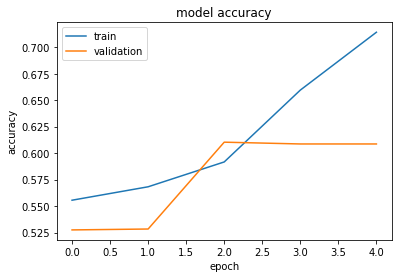

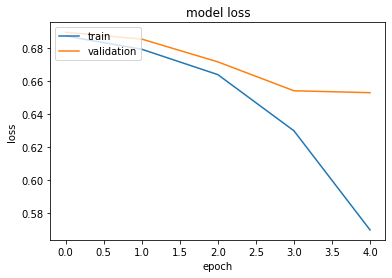

37/37 [==============================] - 0s 5ms/step - loss: 0.6584 - accuracy: 0.6127
Test Accuracy : 0.6126821041107178
Loss : 0.6584259867668152
[[0.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


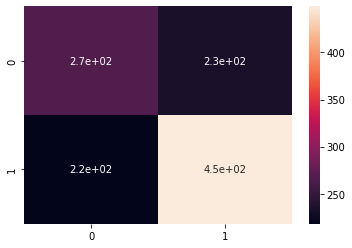

              precision    recall  f1-score   support

           0       0.55      0.53      0.54       500
           1       0.66      0.67      0.67       667

    accuracy                           0.61      1167
   macro avg       0.60      0.60      0.60      1167
weighted avg       0.61      0.61      0.61      1167



In [ ]:
# Convert Binary to Multiclass for LIAR

y_test = y_test.mask(y_test < 0, 0)
y_test = y_test.mask(y_test > 0, 1)

y_train = y_train.mask(y_train < 0, 0)
y_train = y_train.mask(y_train > 0, 1)
                     
y_valid = y_valid.mask(y_valid < 0, 0)
y_valid = y_valid.mask(y_valid > 0, 1)


modelv11 = model1_1(x_train.shape[1], 0.001, vocab3)
history = fit_model(modelv11, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv11, x_test, y_test)
pred_confusion(modelv11, x_test, y_test, 1)



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 dropout_38 (Dropout)        (None, 50, 100)           0         
                                                                 
 global_max_pooling1d_16 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dense_62 (Dense)            (None, 100)               10100     
                                                                 
 dense_63 (Dense)            (None, 50)                5050      
                                                     

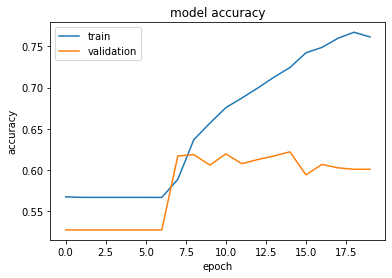

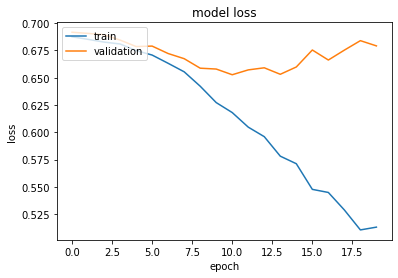

37/37 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5690
Test Accuracy : 0.5689802765846252
Loss : 0.689419686794281
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


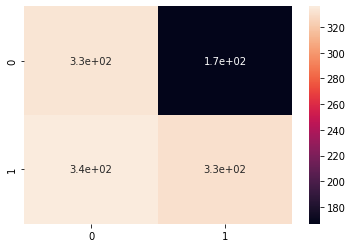

              precision    recall  f1-score   support

           0       0.50      0.67      0.57       500
           1       0.66      0.50      0.57       667

    accuracy                           0.57      1167
   macro avg       0.58      0.58      0.57      1167
weighted avg       0.59      0.57      0.57      1167



In [ ]:
# LIAR FNN TEXT Binary
modelv22 = model2_1(x_train.shape[1], 0.001, vocab3)
history = fit_model(modelv22, x_train, y_train, x_valid,y_valid, 20)
plot_history(history)
evaluate(modelv22, x_test, y_test)
pred_confusion(modelv22, x_test, y_test, 1)

In [ ]:
# LIAR CNN Multiclass

def model3(shape, lr, vocab_text_size):
  opt = tf.keras.optimizers.Adam(learning_rate= lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_text_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Dropout(rate=0.5))
  model.add(Conv1D(input_shape=(shape,1),filters=64 ,kernel_size=3, padding='same', activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(rate=0.5))
  #modelv1.add(Conv1D(input_shape=(1200,1),filters=128 ,kernel_size=5, padding='same', activation='relu'))
  #modelv1.add(MaxPooling1D(5))
  #model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
  print(model.summary())
  return model


In [80]:
x_test, x_train, x_valid = liar_word_seq_data()
y_test, y_train, y_valid = liar_label_seq_data()

(1167, 50)
(9465, 50)
(1183, 50)
(1167, 1)
(9465, 1)
(1183, 1)


In [81]:
for i in range(y_test.shape[0]):
  if y_test.loc[i].label < 0:
    y_test.loc[i].label = y_test.loc[i].label + 3
  else:
     y_test.loc[i].label = y_test.loc[i].label + 2

for i in range(y_train.shape[0]):
  if y_train.loc[i].label < 0:
    y_train.loc[i].label = y_train.loc[i].label + 3
  else:
     y_train.loc[i].label = y_train.loc[i].label + 2

for i in range(y_valid.shape[0]):
  if y_valid.loc[i].label < 0:
    y_valid.loc[i].label = y_valid.loc[i].label + 3
  else:
     y_valid.loc[i].label = y_valid.loc[i].label + 2


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 dropout_56 (Dropout)        (None, 50, 100)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 50, 64)            19264     
                                                                 
 dropout_57 (Dropout)        (None, 50, 64)            0         
                                                                 
 global_max_pooling1d_24 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                                                     

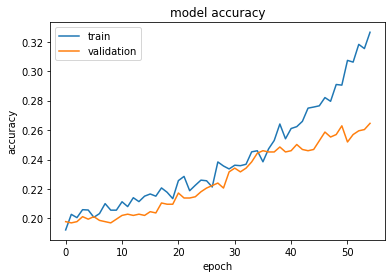

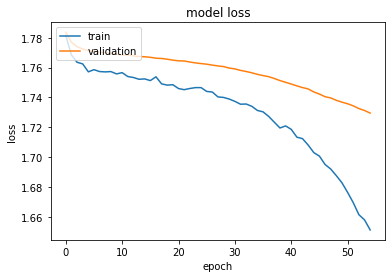

37/37 [==============================] - 0s 5ms/step - loss: 1.7304 - accuracy: 0.2596
Test Accuracy : 0.259640097618103
Loss : 1.730437159538269
[1 4 4 ... 1 1 1]


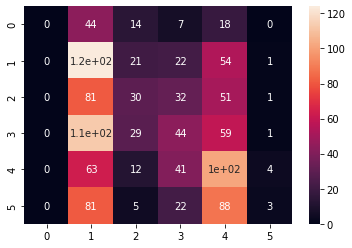

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.25      0.56      0.34       222
           2       0.27      0.15      0.20       195
           3       0.26      0.18      0.21       246
           4       0.27      0.46      0.34       222
           5       0.30      0.02      0.03       199

    accuracy                           0.26      1167
   macro avg       0.23      0.23      0.19      1167
weighted avg       0.25      0.26      0.21      1167



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# LIAR FNN Multiclass

modelv3 = model3(x_train.shape[1], 0.0001, vocab3)
history = fit_model(modelv3, x_train, y_train, x_valid,y_valid, 55)
plot_history(history)
evaluate(modelv3, x_test, y_test)
pred_confusion(modelv3, x_test, y_test, 6)

In [89]:
# FNN FOR MULTICLASS LIAR
def model4(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Dropout(rate=0.5))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(rate=0.5))
  model.add(Dense(units = 100 , activation = 'relu' ,input_shape=(shape,1)))
  model.add(Dense(units = 50 , activation = 'relu'))
  model.add(Dense(units = 25 , activation = 'relu'))
  model.add(Dense(units = 10 , activation = 'relu'))
  model.add(Dense(units = 6 , activation = 'softmax'))
  model.compile(optimizer = opt , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  print(model.summary())
  return model

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 dropout_73 (Dropout)        (None, 50, 100)           0         
                                                                 
 global_max_pooling1d_32 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_74 (Dropout)        (None, 100)               0         
                                                                 
 dense_118 (Dense)           (None, 100)               10100     
                                                                 
 dense_119 (Dense)           (None, 50)                5050      
                                                     

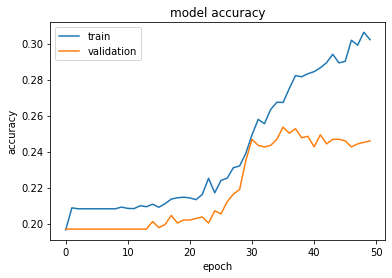

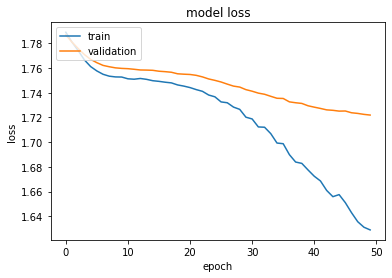

37/37 [==============================] - 0s 3ms/step - loss: 1.7256 - accuracy: 0.2399
Test Accuracy : 0.23993144929409027
Loss : 1.7256219387054443
[1 1 3 ... 3 3 1]


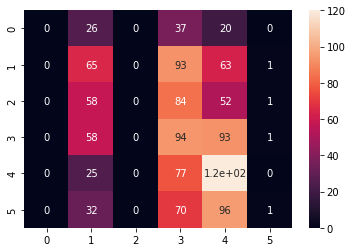

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.25      0.29      0.27       222
           2       0.00      0.00      0.00       195
           3       0.21      0.38      0.27       246
           4       0.27      0.54      0.36       222
           5       0.25      0.01      0.01       199

    accuracy                           0.24      1167
   macro avg       0.16      0.20      0.15      1167
weighted avg       0.18      0.24      0.18      1167



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
modelv4 = model4(x_train.shape[1], 0.0001, vocab3)
history = fit_model(modelv4, x_train, y_train, x_valid,y_valid, 50)
plot_history(history)
evaluate(modelv4, x_test, y_test)
pred_confusion(modelv4, x_test, y_test, 6)